In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import re
import flair
from nltk.corpus import stopwords
from scipy.stats import spearmanr

In [46]:
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-05-03 23:53:07,795 loading file C:\Users\007ra\.flair\models\sentiment-en-mix-distillbert_4.pt


In [6]:
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text

In [7]:
dataFrame = pd.read_csv('./data/daily.csv')
dataFrame = dataFrame[6200:6250]
print(dataFrame)

           Day  Price
6200  20210813   3.95
6201  20210816   3.93
6202  20210817   3.92
6203  20210818   3.86
6204  20210819   3.83
6205  20210820   3.94
6206  20210823   3.93
6207  20210824   3.95
6208  20210825   4.03
6209  20210826   4.07
6210  20210827   4.35
6211  20210830   4.25
6212  20210831   4.33
6213  20210901   4.45
6214  20210902   4.65
6215  20210903   4.77
6216  20210907   4.71
6217  20210908   4.66
6218  20210909   4.97
6219  20210910   5.13
6220  20210913   5.21
6221  20210914   5.39
6222  20210915   5.66
6223  20210916   5.52
6224  20210917   5.32
6225  20210920   5.25
6226  20210921   4.96
6227  20210922   4.92
6228  20210923   4.94
6229  20210924   5.10
6230  20210927   5.53
6231  20210928   5.94
6232  20210929   5.73
6233  20210930   5.58
6234  20211001   5.61
6235  20211004   5.80
6236  20211005   6.37
6237  20211006   6.00
6238  20211007   5.71
6239  20211008   5.46
6240  20211011   5.46
6241  20211012   5.34
6242  20211013   5.56
6243  20211014   5.92
6244  2021

In [34]:
sentence = flair.data.Sentence(cleanText('the food was great!'))
sentiment_model.predict(sentence)
sentence

Sentence: "the food was great !" → POSITIVE (0.9961)

In [43]:
sentence = flair.data.Sentence('gas prices are increasing due to war')
sentiment_model.predict(sentence)
sentence

Sentence: "gas prices are increasing due to war" → NEGATIVE (0.9882)

In [44]:
testimonial = TextBlob("gas prices are increasing due to war")
print(testimonial.sentiment.polarity*testimonial.sentiment.subjectivity)

-0.046875


In [20]:
data = {}
MAX_TWEETS = 25


for n in range (1, len(dataFrame['Day'])):
    PREV = str(list(dataFrame.Day)[n-1])[:4]+'-'+str(list(dataFrame.Day)[n-1])[4:6]+'-'+str(list(dataFrame.Day)[n-1])[6:]
    PRES = str(list(dataFrame.Day)[n])[:4]+'-'+str(list(dataFrame.Day)[n])[4:6]+'-'+str(list(dataFrame.Day)[n])[6:]
    QUERY = f"natural gas (natural OR gas OR import OR export OR price) until:{PRES} since:{PREV} -filter:links -filter:replies"
    print(f'checking for {PREV} - {PRES}', end = ' ')
    curr = 0.0
    nums = 0
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(QUERY).get_items()):
        nums += 1
        if i>MAX_TWEETS:
            break
        sentence = flair.data.Sentence(cleanText(tweet.content))
        sentiment_model.predict(sentence)
        try:
            if(sentence.labels[0].value == 'POSITIVE'):
                curr += sentence.labels[0].score
            elif(sentence.labels[0].value == 'NEGATIVE'):
                curr -= sentence.labels[0].score
            else:
                print(f'The sentiment is {sentence.labels[0].value}')
        except:
            pass
    print(f"The sentiment is {curr/nums}")
    dataFrame.loc[dataFrame.Price == list(dataFrame['Price'])[n], 'Sentiment'] = curr/nums
    data[PRES] = curr/nums

checking for 2021-08-13 - 2021-08-16 The sentiment is -0.5403736680746078
checking for 2021-08-16 - 2021-08-17 The sentiment is -0.5155494709809622
checking for 2021-08-17 - 2021-08-18 The sentiment is -0.9985878765583038
checking for 2021-08-18 - 2021-08-19 The sentiment is 0.03554887121373957
checking for 2021-08-19 - 2021-08-20 The sentiment is 0.47822482883930206
checking for 2021-08-20 - 2021-08-23 The sentiment is -0.48193468153476715
checking for 2021-08-23 - 2021-08-24 The sentiment is -0.997829258441925
checking for 2021-08-24 - 2021-08-25 The sentiment is -0.17905185222625733
checking for 2021-08-25 - 2021-08-26 The sentiment is 0.988865315914154
checking for 2021-08-26 - 2021-08-27 The sentiment is -0.5335312128067017
checking for 2021-08-27 - 2021-08-30 The sentiment is -0.8252368420362473
checking for 2021-08-30 - 2021-08-31 The sentiment is -0.4436781406402588
checking for 2021-08-31 - 2021-09-01 The sentiment is -0.2455471158027649
checking for 2021-09-01 - 2021-09-02 Th

In [21]:
print(dataFrame)

           Day  Price  Sentiment
6200  20210813   3.95  -0.997829
6201  20210816   3.93  -0.481935
6202  20210817   3.92  -0.515549
6203  20210818   3.86  -0.998588
6204  20210819   3.83   0.035549
6205  20210820   3.94   0.478225
6206  20210823   3.93  -0.481935
6207  20210824   3.95  -0.997829
6208  20210825   4.03  -0.179052
6209  20210826   4.07   0.988865
6210  20210827   4.35  -0.533531
6211  20210830   4.25  -0.825237
6212  20210831   4.33  -0.443678
6213  20210901   4.45  -0.245547
6214  20210902   4.65  -0.574331
6215  20210903   4.77  -0.531468
6216  20210907   4.71  -0.367235
6217  20210908   4.66  -0.549873
6218  20210909   4.97  -0.274687
6219  20210910   5.13  -0.522434
6220  20210913   5.21  -0.697126
6221  20210914   5.39  -0.123301
6222  20210915   5.66  -0.648412
6223  20210916   5.52  -0.359431
6224  20210917   5.32  -0.586008
6225  20210920   5.25  -0.457394
6226  20210921   4.96  -0.562847
6227  20210922   4.92  -0.354746
6228  20210923   4.94  -0.121188
6229  2021

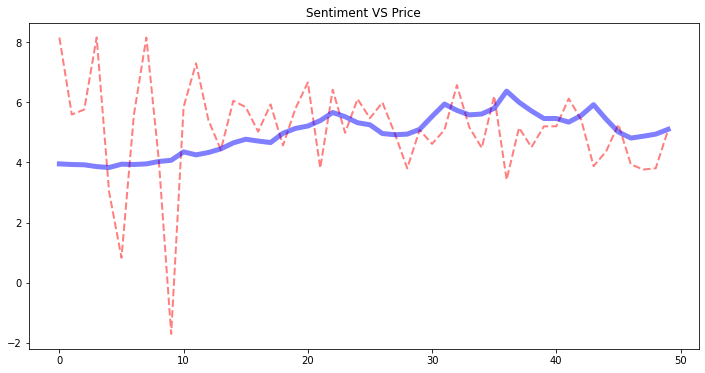

In [22]:
avg = sum(list(dataFrame.Price))/len(list(dataFrame.Price))
sen = list(dataFrame.Sentiment)
price = list(dataFrame.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+3.2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='red', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [23]:
spearmanr(sen, price)

SpearmanrResult(correlation=-0.08635926993275697, pvalue=0.550959541709495)